In [1]:
import os
import csv
import torch
import numpy as np
from torch import nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.ndimage import binary_erosion, binary_dilation
from skimage.measure import label, regionprops
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import skeletonize
from skimage import transform
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from datasets import SkullUSDataset
from models import ConvNeXtTiny, SimpleUNet
from utils import warp_ellipse, robust_fit_ellipse, ellipse_to_mask

In [2]:
def load_atlas_sample(path):
    image = imread(path).copy()[..., 0]
    image[:50, ...] = 0
    image[:150, 700:] = 0
    image[:, :40] = 0
    image_norm = (image - image.mean()) / image.std()
    data = np.repeat(
        np.expand_dims(image_norm, 0), 3, axis=0
    ).astype(np.float32)
    
    return data, image

Best 000_HC 111.5516357421875 92.29122924804688 409.3111267089844 377.701904296875 -1.1167994598534445
Best 001_HC 114.05908966064453 87.68492126464844 402.5675354003906 221.2359161376953 -0.15210911631584167
Best 002_HC 193.700439453125 159.04969787597656 283.67449951171875 191.96304321289062 -1.5707963267948966
Best 003_HC 130.5 110.0 415.8426513671875 357.7397155761719 0.0
Best 004_HC 179.12098693847656 135.24232482910156 337.8426818847656 292.5060119628906 0.7481581568717957
Best 005_HC 105.08088684082031 86.81698608398438 322.572265625 237.12567138671875 -0.5164073705673218
Best 006_HC 178.87863159179688 149.975341796875 429.7913818359375 245.5298309326172 -1.5707963267948966
Best 007_HC 100.36820983886719 82.90282440185547 446.4713134765625 370.6037902832031 -0.6065953969955444
Best 008_HC 140.41990661621094 113.59256744384766 376.9039611816406 334.26129150390625 0.29794028401374817
Best 009_HC 92.37489318847656 71.92477416992188 431.24859619140625 217.22506713867188 -1.570796326

Best 064_HC 191.42701721191406 163.37220764160156 344.70416259765625 308.9415588378906 -0.9821675578739981
Best 065_HC 166.50765991210938 122.2139892578125 264.9759826660156 268.18084716796875 -0.8153724233296256
Best 066_2HC 216.14031982421875 162.3015899658203 385.1529235839844 275.6611022949219 -0.5744533538818359
Best 066_HC 198.47874450683594 159.64315795898438 342.2348937988281 278.68365478515625 -0.49387961626052856
Best 067_HC 127.69677734375 105.25304412841797 475.3198547363281 294.99969482421875 -1.526203271993671
Best 068_2HC 248.5789337158203 199.16163635253906 338.1871643066406 282.4956970214844 -0.683929979801178
Best 068_HC 249.0965118408203 192.8438720703125 457.3341369628906 259.53948974609375 -0.8184248963978629
Best 069_HC 196.55319213867188 161.34735107421875 292.4818115234375 252.77243041992188 -1.5707963267948966
Best 070_HC 131.0144805908203 110.15968322753906 522.5949096679688 326.2958068847656 -1.2809231440213065
Best 071_HC 97.30970001220703 84.05802917480469 

Best 126_HC 231.8850555419922 193.15061950683594 338.3516845703125 232.32684326171875 -0.1631053239107132
Best 127_HC 128.1856231689453 112.27082824707031 452.49945068359375 387.7917785644531 -1.5707963267948966
Best 128_HC 155.6476287841797 136.59083557128906 448.3269348144531 311.9023742675781 -0.22322377562522888
Best 129_HC 138.14175415039062 105.43721771240234 407.3441162109375 260.91485595703125 -1.5707963267948966
Best 130_HC 148.0332794189453 121.48883819580078 360.0910949707031 237.6514434814453 0.6695457100868225
Best 131_HC 213.54905700683594 177.89077758789062 371.18310546875 251.6035614013672 -1.5480011767384152
Best 132_HC 127.24186706542969 89.69146728515625 465.4306640625 305.478515625 0.5664682984352112
Best 133_2HC 186.68260192871094 137.90589904785156 412.6439514160156 257.99285888671875 -0.21433298289775848
Best 133_3HC 125.9916763305664 100.02159881591797 417.26971435546875 301.4178161621094 0.5535354614257812
Best 133_4HC 191.0509796142578 144.1305694580078 360.52

Best 192_2HC 205.02511596679688 142.5341796875 425.8679504394531 272.6763610839844 0.7510638236999512
Best 192_HC 177.918212890625 143.24867248535156 352.9564514160156 308.5961608886719 -1.5707963267948966
Best 193_2HC 139.29127502441406 113.39246368408203 413.3108825683594 247.2004852294922 -0.6112794280052185
Best 193_HC 178.6939239501953 128.1396484375 396.4892883300781 302.2706604003906 -0.032146282494068146
Best 194_HC 231.5 184.5 395.8028869628906 236.20980834960938 0.0
Best 195_2HC 267.0848083496094 215.7337646484375 404.025146484375 260.4825134277344 0.07651658356189728
Best 195_HC 256.17333984375 203.02297973632812 387.26678466796875 275.53759765625 0.1116584837436676
Best 196_HC 140.86978149414062 121.49720764160156 452.0871276855469 263.9217529296875 -0.11145346611738205
Best 197_HC 288.9806823730469 208.9788055419922 401.72442626953125 259.87420654296875 0.030383436009287834
Best 198_2HC 253.08042907714844 194.15139770507812 391.0956115722656 269.3290710449219 -0.0152083635

Best 250_HC 192.47982788085938 151.46693420410156 405.61407470703125 261.7882385253906 -0.3154202997684479
Best 251_HC 260.28509521484375 199.10157775878906 407.7742919921875 263.173828125 -0.011464029550552368
Best 252_HC 242.01995849609375 197.7689971923828 447.9468994140625 305.76873779296875 -0.23455311357975006
Best 253_HC 263.0722351074219 194.36932373046875 406.7012634277344 291.01458740234375 0.06897371262311935
Best 254_HC 232.77957153320312 194.32179260253906 377.7549133300781 267.4440002441406 -0.09275853633880615
Best 255_HC 253.2597198486328 195.45054626464844 391.5269470214844 278.85455322265625 0.03864618390798569
Best 256_HC 250.5 200.0 432.2964172363281 273.77691650390625 0.0
Best 257_HC 205.76954650878906 158.85586547851562 365.5989685058594 312.3793029785156 0.004581224173307419
Best 258_HC 203.82276916503906 171.251220703125 410.3750915527344 182.68601989746094 0.48251277208328247
Best 259_HC 276.8406982421875 202.1075439453125 381.404296875 278.8507385253906 0.0345

Best 321_HC 286.0131530761719 217.33712768554688 374.4798278808594 229.61065673828125 0.026549015194177628
Best 322_HC 208.24366760253906 174.11810302734375 417.2944641113281 230.8236083984375 0.027690719813108444
Best 323_2HC 268.75274658203125 207.7618865966797 431.76763916015625 245.53717041015625 0.04064005985856056
Best 323_HC 292.6905822753906 231.20632934570312 386.0996398925781 241.98556518554688 -0.030589552596211433
Best 324_HC 217.0 174.0 362.5850524902344 293.5175476074219 0.0
Best 325_HC 288.8153076171875 218.541015625 400.2623291015625 266.8558349609375 -0.005784737877547741
Best 326_HC 227.56578063964844 169.16729736328125 336.4613342285156 288.14849853515625 0.214181050658226
Best 327_2HC 321.6459655761719 230.9060821533203 409.2757873535156 275.5244140625 0.02466762624680996
Best 327_HC 315.819580078125 230.84971618652344 412.3038024902344 252.2373504638672 0.10880362242460251
Best 328_HC 280.70989990234375 215.99618530273438 393.01416015625 293.1103820800781 -0.038295

Best 388_HC 170.43270874023438 122.57772827148438 379.9068603515625 318.7650146484375 0.06641335040330887
Best 389_HC 288.3395080566406 224.5284881591797 434.6021728515625 302.9742126464844 -0.021049387753009796
Best 390_HC 253.03341674804688 206.9242401123047 403.2720642089844 280.0169677734375 0.0031303679570555687
Best 391_HC 222.59080505371094 175.44442749023438 393.8328552246094 270.52099609375 0.03954183682799339
Best 392_2HC 210.5051727294922 171.48130798339844 349.74322509765625 250.19842529296875 0.2813226580619812
Best 392_3HC 210.5051727294922 171.48130798339844 349.74322509765625 250.19842529296875 0.2813226580619812
Best 392_HC 210.5051727294922 171.48130798339844 349.74322509765625 250.19842529296875 0.2813226580619812
Best 393_HC 294.8686828613281 236.24374389648438 388.1438293457031 274.98565673828125 -0.021845001727342606
Best 394_2HC 267.26800537109375 228.9942626953125 444.67852783203125 245.04144287109375 0.07573720067739487
Best 394_HC 251.52037048339844 215.952636

Best 452_HC 260.79437255859375 202.345458984375 415.0177001953125 269.49072265625 0.13810139894485474
Best 453_2HC 239.8153839111328 176.32554626464844 399.5343017578125 289.41204833984375 -0.19623734056949615
Best 453_HC 289.0 199.5 407.58587646484375 298.87811279296875 0.0
Best 454_HC 244.6305694580078 200.2484130859375 393.86474609375 303.3749084472656 0.008958438411355019
Best 455_HC 226.6013946533203 170.9593048095703 366.7905578613281 291.3547058105469 0.052323613315820694
Best 456_HC 218.3038787841797 162.6440887451172 347.1191711425781 314.38336181640625 -0.08419100195169449
Best 457_2HC 181.6326904296875 152.7381591796875 420.8001708984375 231.59002685546875 -0.08329207450151443
Best 457_HC 236.3603515625 198.17274475097656 338.4024658203125 284.1528625488281 0.05104923993349075
Best 458_HC 283.95416259765625 207.71437072753906 353.7801208496094 244.34524536132812 -0.060914546251297
Best 459_HC 225.5 161.0 332.878173828125 265.1588439941406 0.0
Best 460_HC 227.00526428222656 1

Best 517_HC 267.0209655761719 202.12020874023438 415.24322509765625 256.8166809082031 -0.05571804195642471
Best 518_HC 191.03187561035156 146.4157257080078 412.9050598144531 288.31011962890625 -0.14928141236305237
Best 519_HC 215.9669189453125 167.17636108398438 406.4688415527344 254.89346313476562 -0.015657491981983185
Best 520_HC 270.9368591308594 210.085693359375 405.7545471191406 258.1473388671875 0.06208023428916931
Best 521_HC 294.3620300292969 212.667236328125 348.35260009765625 253.30467224121094 0.05466216430068016
Best 522_HC 271.0809326171875 206.30258178710938 458.60369873046875 271.76171875 0.010120023973286152
Best 523_HC 189.19918823242188 138.487060546875 443.4277648925781 288.11981201171875 -0.062238819897174835
Best 524_HC 234.3778839111328 182.824462890625 410.9469299316406 216.9539337158203 0.07994090765714645
Best 525_HC 243.0461883544922 194.31988525390625 393.7887878417969 287.1830749511719 -0.09619894623756409
Best 526_2HC 225.76870727539062 181.2630615234375 39

Best 583_2HC 212.42576599121094 161.7608642578125 318.42828369140625 327.77960205078125 -0.10336542874574661
Best 583_HC 221.9783172607422 162.244140625 388.65179443359375 335.9435729980469 0.12022429704666138
Best 584_HC 162.88360595703125 129.05799865722656 378.03216552734375 281.3798828125 0.39413195848464966
Best 585_HC 300.0714416503906 220.4013671875 381.2884521484375 263.8954162597656 -0.06981406360864639
Best 586_HC 217.8955841064453 183.504638671875 406.58880615234375 314.5720520019531 0.046343524008989334
Best 587_2HC 200.3736114501953 159.4330291748047 426.58038330078125 277.0172119140625 0.031961943954229355
Best 587_HC 196.6366424560547 143.9499969482422 426.0461730957031 333.9698486328125 -0.03644793480634689
Best 588_2HC 273.5 210.0 412.0755310058594 299.80755615234375 0.0
Best 588_HC 203.0653533935547 153.41299438476562 359.2654724121094 279.0594787597656 0.014065258204936981
Best 589_HC 243.43792724609375 204.59544372558594 405.321044921875 272.111083984375 0.248788312

Best 649_HC 291.8038635253906 211.8367919921875 347.04022216796875 253.2261505126953 0.0405997596681118
Best 650_HC 178.6777801513672 127.17342376708984 375.083740234375 294.5951843261719 -1.5707963267948966
Best 651_HC 253.770263671875 202.19845581054688 364.9290466308594 242.61517333984375 0.02569236047565937
Best 652_2HC 238.9265594482422 193.94187927246094 377.32769775390625 241.33905029296875 -0.28480079770088196
Best 652_HC 243.49436950683594 181.6016387939453 317.0482177734375 305.57977294921875 0.06114189326763153
Best 653_HC 175.87591552734375 134.34622192382812 413.28936767578125 275.53582763671875 -0.03816397488117218
Best 654_HC 299.55914306640625 207.25735473632812 466.86358642578125 240.642822265625 -0.22434353828430176
Best 655_HC 214.3367156982422 174.54080200195312 322.62799072265625 278.77789306640625 0.19680941104888916
Best 656_HC 283.8310852050781 211.28909301757812 406.0460205078125 297.7343444824219 -0.02653411217033863
Best 657_2HC 273.46014404296875 221.8832702

Best 715_HC 223.3463592529297 169.77978515625 394.1217041015625 295.6094970703125 0.034120384603738785
Best 716_HC 220.3729705810547 173.2177276611328 365.9799499511719 326.8330078125 0.01171798910945654
Best 717_2HC 272.04083251953125 216.4649658203125 444.58837890625 238.56491088867188 0.04884098842740059
Best 717_HC 286.3356628417969 214.3969268798828 397.3217468261719 272.4271545410156 0.12181301414966583
Best 718_2HC 194.24639892578125 152.1453857421875 372.93060302734375 288.64312744140625 0.6364426016807556
Best 718_HC 212.69186401367188 162.30690002441406 374.4646301269531 255.0535888671875 0.7585158944129944
Best 719_HC 218.84774780273438 167.97021484375 355.386962890625 265.39923095703125 0.20839424431324005
Best 720_2HC 259.192138671875 201.94454956054688 382.78228759765625 273.07958984375 0.07890969514846802
Best 720_HC 258.4609680175781 201.9517822265625 383.0970764160156 273.48748779296875 0.0687418058514595
Best 721_HC 258.90411376953125 204.21817016601562 367.7277832031

Best 778_HC 216.39634704589844 180.6265106201172 383.5248718261719 270.6546630859375 -0.051643095910549164
Best 779_2HC 158.3590850830078 122.0233383178711 428.807861328125 223.111572265625 -0.41628068685531616
Best 779_HC 161.77406311035156 127.99547576904297 371.8888244628906 213.57015991210938 -0.493478387594223
Best 780_2HC 232.61053466796875 196.29376220703125 397.9296875 269.3398132324219 -0.225620299577713
Best 780_HC 241.27352905273438 199.0889892578125 397.6707763671875 268.7513427734375 -0.348388671875
Best 781_HC 202.5 172.0 350.8060302734375 289.8116760253906 0.0
Best 782_HC 247.86033630371094 226.94261169433594 380.7423400878906 254.88511657714844 -0.3475911021232605
Best 783_2HC 187.96485900878906 135.31983947753906 416.5678405761719 317.8070373535156 0.05516485497355461
Best 783_3HC 185.6114959716797 138.09983825683594 396.88934326171875 309.68280029296875 0.20546697080135345
Best 783_4HC 235.32826232910156 176.81802368164062 409.9533386230469 266.6711730957031 -0.101761

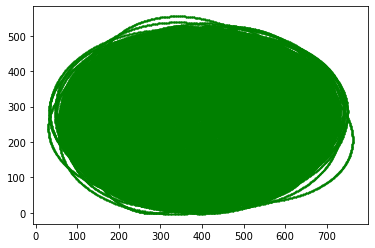

In [3]:
training_path = 'training_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'
if not os.path.exists(training_path):
    !wget -O training_set.zip https://zenodo.org/record/1327317/files/training_set.zip?download=1
    !unzip training_set.zip && rm training_set.zip

subjects = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])
fig = plt.figure()
params = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for im_name in subjects:
    subject = im_name.split('.')[0]
    label_name = '{:}_Annotation.png'.format(subject) 

    im_path = os.path.join(training_path, im_name)
    im = imread(im_path)
    label_path = os.path.join(training_path, label_name)
    labels = imread(label_path)
    best_a, best_b, best_x0, best_y0, best_theta = robust_fit_ellipse(labels > 0)

    print('Best', subject, best_a, best_b, best_x0, best_y0, best_theta)
    n_points = 1000
    angles = (np.arange(n_points) / n_points) * 2 * np.pi
    ideal_x = best_a * np.cos(angles)
    ideal_y = best_b * np.sin(angles)

    new_x = ideal_x * np.cos(best_theta) - ideal_y * np.sin(best_theta) + best_x0
    new_y = ideal_y * np.cos(best_theta) + ideal_x * np.sin(best_theta) + best_y0

    plt.scatter(new_x, new_y, s=1, c='g')
    plt.scatter(best_x0, best_y0, s=1, c='g')
    
    params.append([subject, best_a, best_b, best_x0, best_y0, best_theta])

with open(
        os.path.join(training_path, csv_name), 'w'
) as csvfile:
    evalwriter = csv.writer(csvfile)
    for param in params:
        evalwriter.writerow(param)

env: CUDA_LAUNCH_BLOCKING=1
Network created on device cuda:0 with training losses [xentropy] and validation losses [xent, dsc, fn, fp]
Subject 0 1


/home/mariano/p37/lib/python3.7/site-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Subject 1 10
Subject 2 11.2
Subject 3 11
Subject 4 12.1
Subject 5 12.2
Subject 6 12
Subject 7 13.1
Subject 8 13.2
Subject 9 13.3
Subject 10 13
Subject 11 14.1
Subject 12 14
Subject 13 15.1
Subject 14 15.2
Subject 15 15.3
Subject 16 15
Subject 17 16.1
Subject 18 16.2
Subject 19 16.3
Subject 20 16
Subject 21 17.2
Subject 22 17.3
Subject 23 17.4
Subject 24 17
Subject 25 18.1
Subject 26 18.2
Subject 27 18
Subject 28 19
Subject 29 2.1
Subject 30 2.2
Subject 31 2.3
Subject 32 2
Subject 33 3.1
Subject 34 3.2
Subject 35 3.3
Subject 36 3
Subject 37 4.1
Subject 38 4.2
Subject 39 4
Subject 40 5.1
Subject 41 5.2
Subject 42 5
Subject 43 6
Subject 44 7.1
Subject 45 7.2
Subject 46 7
Subject 47 8.1
Subject 48 8.2
Subject 49 8
Subject 50 9.1
Subject 51 9.2
Subject 52 9.3
Subject 53 9


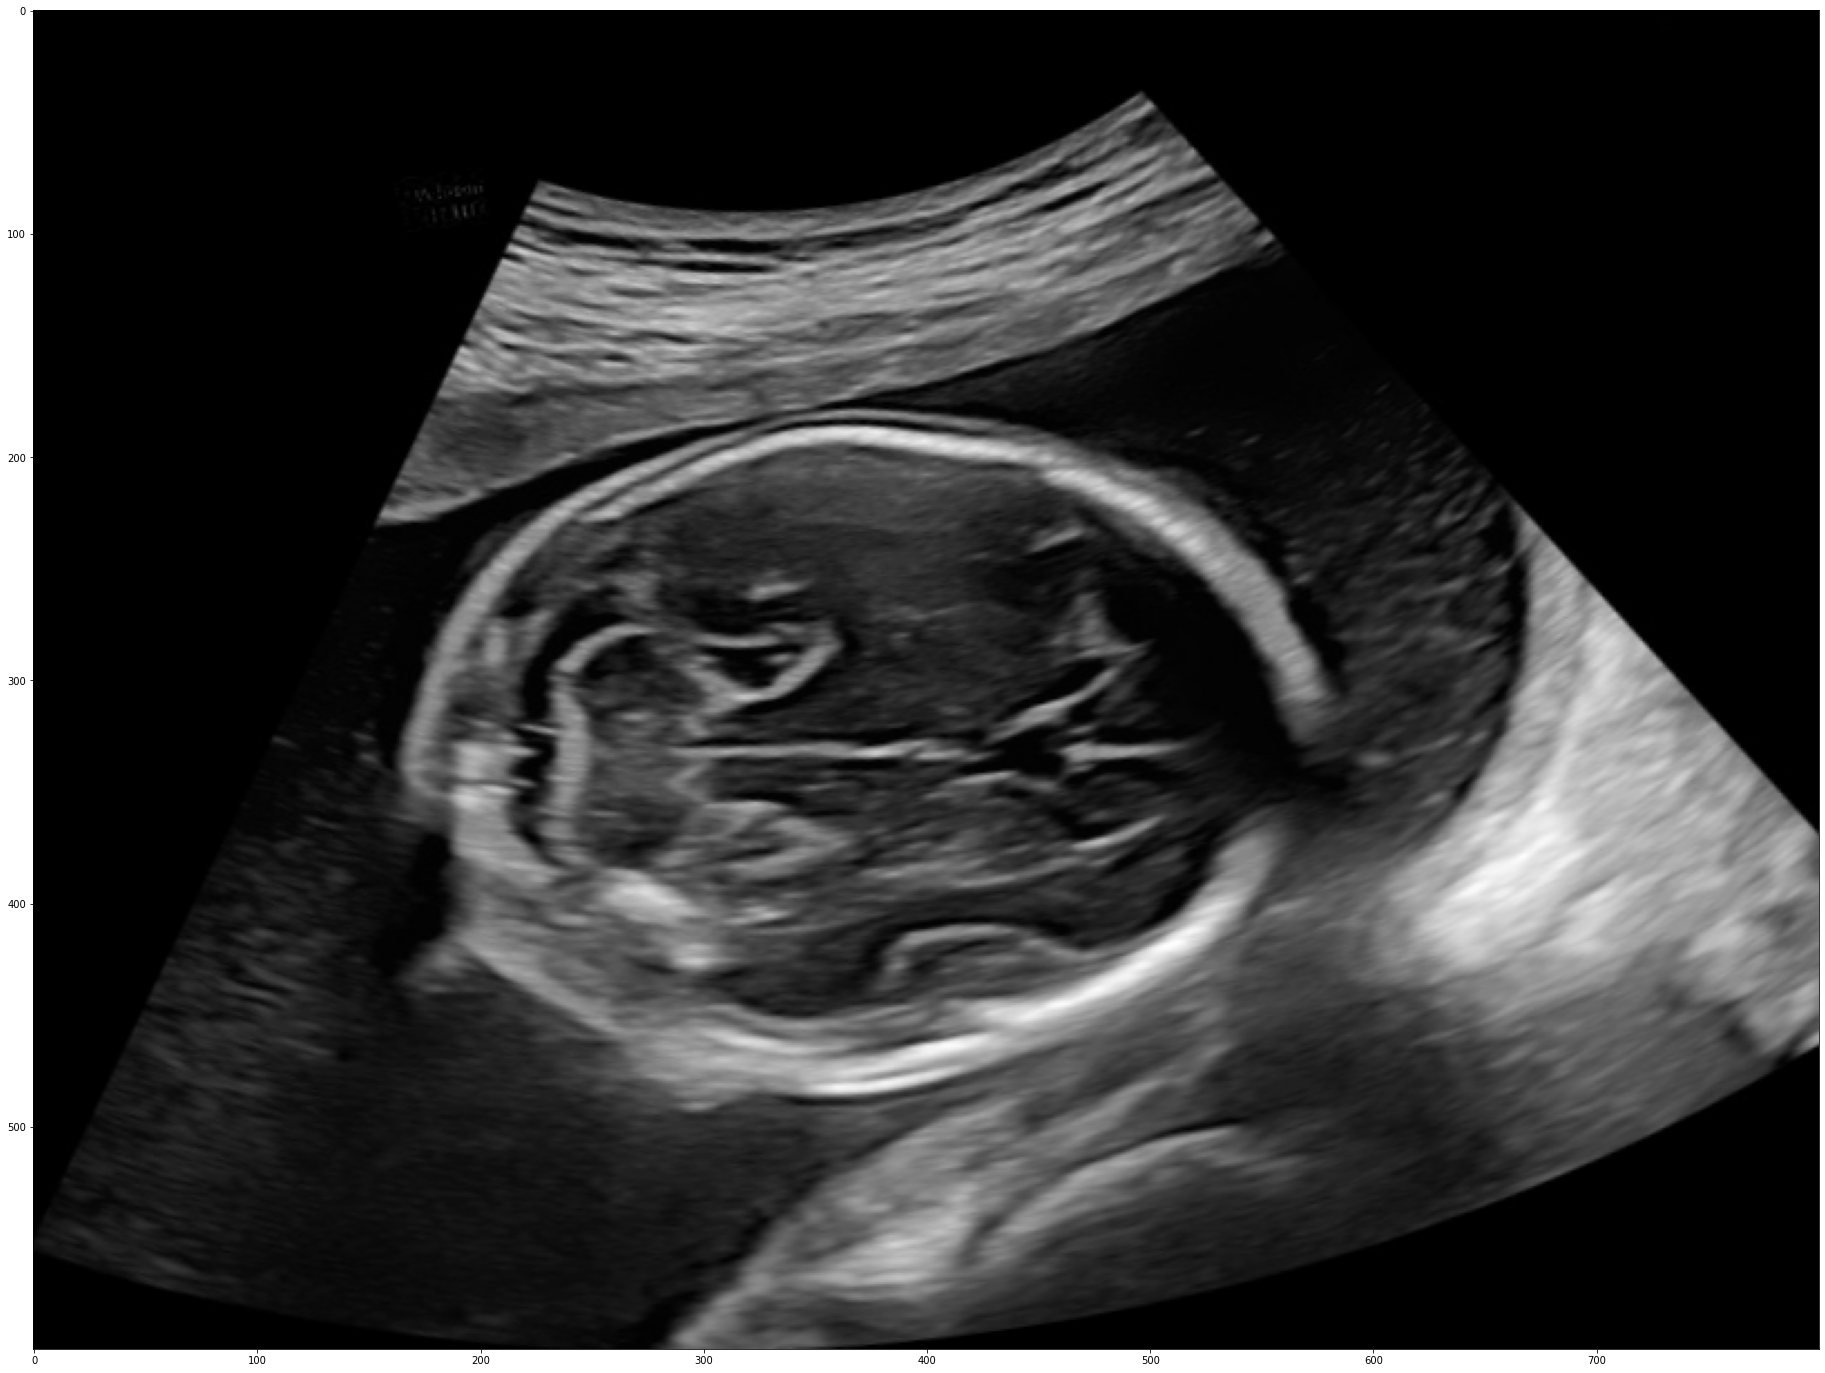

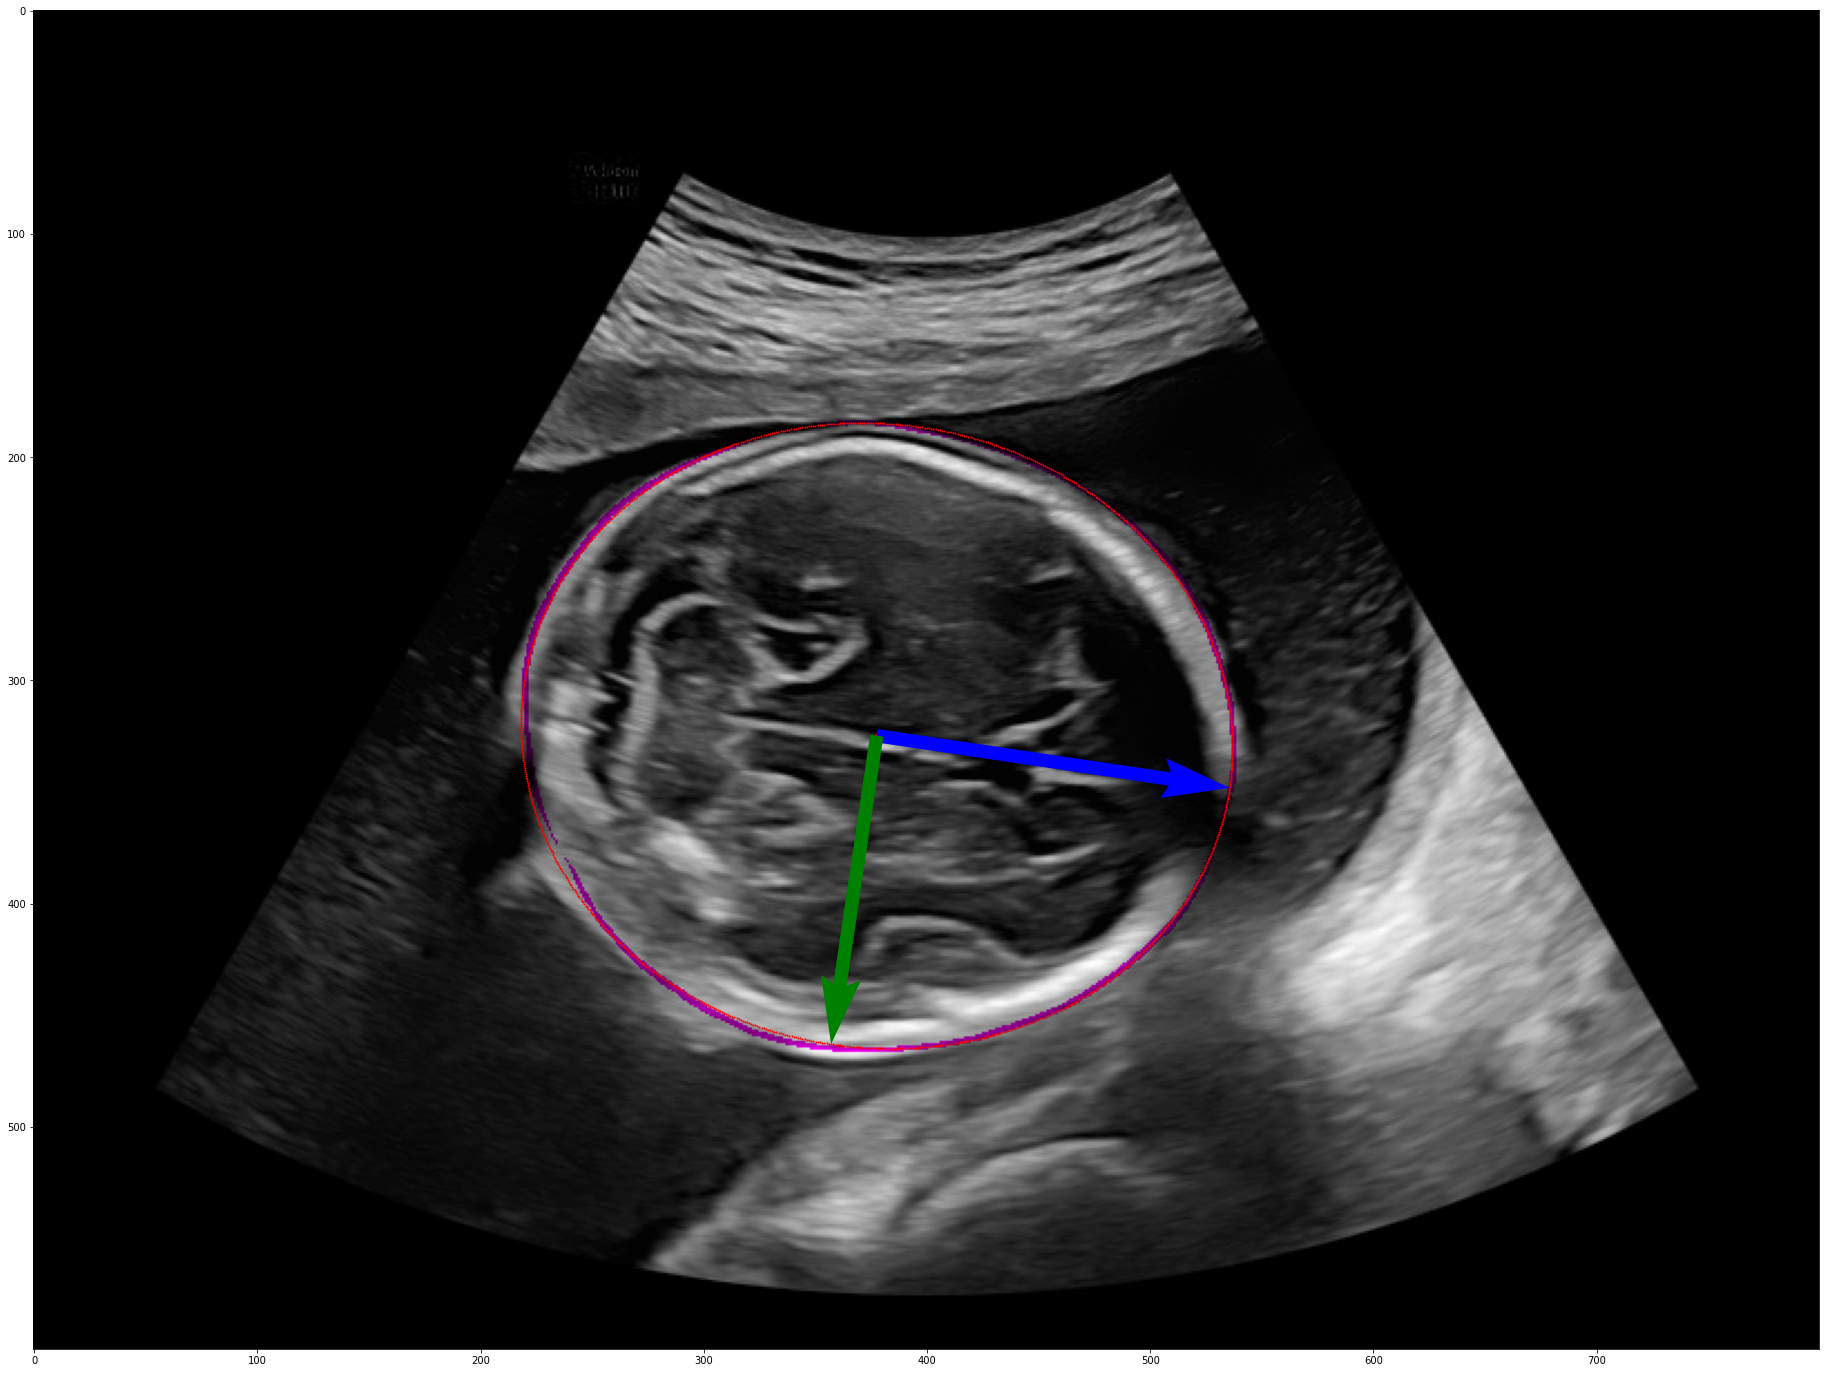

In [4]:
%env CUDA_LAUNCH_BLOCKING=1

training_path = 'training_set/'
testing_path = 'atlas_samples/'
output_path = 'testing_set/'
csv_name = 'parameters.csv'
im_suffix = 'HC.png'

n_folds = 5
val_split = 0.1
train_size = 8
test_size = 8
epochs = 50
patience = 50

training_set = sorted([
    f for f in os.listdir(training_path)
    if f.endswith(im_suffix)
])
testing_set = sorted(os.listdir(testing_path))

im_size = (540, 800)
half_x = im_size[1] / 2
half_y = im_size[0] / 2

n_points = 1000
angles = (np.arange(n_points) / n_points) * 2 * np.pi

fig1 = plt.figure(figsize=(32, 42))
fig2 = plt.figure(figsize=(32, 42))


# We account for a validation set or the lack of it. The reason for
# this is that we want to measure forgetting and that is easier to
# measure if we only focus on the training set and leave the testing
# set as an independent generalisation test.
if val_split > 0:
    n_training = int(len(training_set))
    training_set = training_set[int(n_training * val_split):]
    validation_set = training_set[:int(n_training * val_split)]
else:
    validation_set = training_set

net = SimpleUNet()

model_path = os.path.join('models/unet.pt')
try:    
    net.load_model(model_path)
except IOError:
    print('< Training dataset >')
    train_dataset = SkullUSDataset(training_path, csv_name, sub_list=training_set)
    train_loader = DataLoader(
        train_dataset, train_size, True, num_workers=1
    )

    print('< Validation dataset >')
    val_dataset = SkullUSDataset(training_path, csv_name, sub_list=validation_set)
    val_loader = DataLoader(
        val_dataset, test_size, num_workers=1
    )

    print('< Testing dataset >')
    test_dataset = SkullUSDataset(training_path, csv_name, sub_list=testing_set)
    test_loader = DataLoader(
        test_dataset, test_size, num_workers=1
    )

    print(
        'Training / validation / test samples samples = '
        '{:03d} / {:03d} / {:03d} ({:d} parameters)'.format(
            len(train_dataset), len(val_dataset), len(test_dataset),
            sum(p.numel() for p in net.parameters() if p.requires_grad)
        )
    )
    
    net.fit(
        train_loader, val_loader, epochs=epochs, patience=patience
    )

    net.save_model(model_path)
    
    
net.eval()
reference = None
for batch_i, test_subject in enumerate(testing_set):
    sub_code = '.'.join(test_subject.split('.')[:-1])
    print('Subject', batch_i, sub_code)
    data, image = load_atlas_sample(
        os.path.join(testing_path, test_subject)
    )
    with torch.no_grad():
        data_tensor = torch.from_numpy(data).unsqueeze(0).to(net.device)
        seg = torch.sigmoid(net(data_tensor)).detach().cpu().squeeze().numpy()
    a, b, x0, y0, theta = robust_fit_ellipse(seg > 0.5)
    height, width = image.shape
    
    if reference is None:    
        reg_image = warp_ellipse(
            image, theta, height, width, a, b, x0, y0
        )
        reference = reg_image
        ref_mask = ellipse_to_mask(
            torch.tensor(a), torch.tensor(b), torch.tensor(theta),
            torch.tensor(x0), torch.tensor(y0), height, width
        ).numpy() < 0
    else:
        new_mask = ellipse_to_mask(
            torch.tensor(a), torch.tensor(b), torch.tensor(theta),
            torch.tensor(x0), torch.tensor(y0), height, width
        ).numpy() < 0
        mask = np.logical_and(ref_mask, new_mask).astype(np.float32)
        reg_fwd = warp_ellipse(
            image, theta, height, width, a, b, x0, y0
        )
        reg_bck = warp_ellipse(
            image, np.pi + theta, height, width, a, b, x0, y0
        )
        if ssim(reg_fwd * mask, reference * mask) > ssim(reg_bck * mask, reference * mask):
            reg_image = reg_fwd
        else:
            reg_image = reg_bck        

    fig1.clear()
    plt.figure(fig1.number)
    plt.imshow(reg_image, cmap='gray')
    Image.fromarray(reg_image).convert('RGB').save(
        'atlas/{:}_registered.jpg'.format(sub_code)
    )
    
    rgb_image = np.stack([image, image, image], axis=-1)
    rgb_image[seg > 0.5, 1] = seg[seg > 0.5]
    
    fig2.clear()
    plt.figure(fig2.number)
    plt.imshow(rgb_image)

    ideal_x = a * np.cos(angles)
    ideal_y = b * np.sin(angles)
    new_x = ideal_x * np.cos(theta) - ideal_y * np.sin(theta) + x0
    new_y = ideal_y * np.cos(theta) + ideal_x * np.sin(theta) + y0

    plt.scatter(x0, y0, s=20, c='r')
    plt.scatter(new_x, new_y, s=1, c='r')
    plt.quiver(
        x0, y0,
        a * np.cos(theta),
        a * np.sin(theta),
        scale_units='xy', scale=1,
        color='b', angles='xy'
    )
    plt.quiver(
        x0, y0,
        - b * np.sin(theta),
        b * np.cos(theta),
        scale_units='xy', scale=1,
        color='g', angles='xy'
    )
    
    plt.savefig(
        os.path.join(
            output_path,
            '{:}_seg-ellipse.png'.format(sub_code)                
        )
    )